In [1]:
# 3rd Party dependencies.
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.v2 as transforms

from torch.utils.data import DataLoader
from tqdm import tqdm

# 1st Party dependencies.
from cyclegan.generator import Generator as CycleGANGenerator
from pix2pix.generator import Generator as Pix2PixGenerator
from dataset.facades_dataset import FacadesDataset

%matplotlib inline

In [2]:
# Device is required for inference (to speed it up if possible).
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

## Visualisation

In [24]:
def visualise_models_comparison(pix2pix_model, 
                                cyclegan_model, 
                                segmentation_maps, 
                                save_images = False):
    figure, axes = plt.subplots(nrows=len(segmentation_maps), ncols=3, figsize=(15, 20))
    
    for i, label in enumerate(segmentation_maps):
        input = torch.tensor(np.expand_dims(label, 0)).to(device)
        
        pix2pix_fake = pix2pix_model(input)
        pix2pix_fake = pix2pix_fake.detach().cpu().numpy()
        pix2pix_fake = np.transpose(pix2pix_fake[0], (1,2,0))

        cyclegan_fake = cyclegan_model(input)
        cyclegan_fake = cyclegan_fake.detach().cpu().numpy()
        cyclegan_fake = np.transpose(cyclegan_fake[0], (1,2,0))

        label = np.transpose(label.numpy(), (1,2,0))

        axes[i, 0].imshow(cv2.cvtColor(label, cv2.COLOR_BGR2RGB))
        axes[i, 1].imshow(cv2.cvtColor(pix2pix_fake, cv2.COLOR_BGR2RGB))
        axes[i, 2].imshow(cv2.cvtColor(cyclegan_fake, cv2.COLOR_BGR2RGB))

        if save_images:
            cv2.imwrite(os.path.join('out', 'screens', f"labels_{i:03d}.jpg"), (label * 255).astype(np.uint8))
            cv2.imwrite(os.path.join('out', 'screens', f"pix2pix_{i:03d}.jpg"), (pix2pix_fake * 255).astype(np.uint8))
            cv2.imwrite(os.path.join('out', 'screens', f"cyclegan_{i:03d}.jpg"), (cyclegan_fake * 255).astype(np.uint8))

    column_names = ['Segmentation', 'Pix2Pix Generation', 'CycleGAN Generation']
    for i, ax in enumerate(axes.flatten()[:len(column_names)]):
        ax.axis('off')
        ax.set_title(column_names[i], fontweight='bold')

    figure.subplots_adjust(hspace=0.5, bottom=0.1)
    plt.tight_layout(pad=1)
    plt.show()    

In [4]:
pix2pix_model = Pix2PixGenerator().to(device)
pix2pix_model.load_state_dict(torch.load(os.path.join('out', 'weights', 'pix2pix', 'generator-399-13.977.pt')))

cyclegan_model = CycleGANGenerator(img_channels=3, num_residuals=9).to(device)
cyclegan_model.load_state_dict(torch.load(os.path.join('out', 'weights', 'cyclegan', 'generator-y-099-2.589.pt')))

<All keys matched successfully>

## Val images

**Pix2Pix** looks much better than **CycleGAN**.

In [7]:
default_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])
facades_val_dataset = FacadesDataset(root_dir='dataset/facades', split='val', transformations=default_transforms)

validation_samples = np.random.choice(range(len(facades_val_dataset)), 10)
segmentation_maps = []
for i in validation_samples:
    _, label = facades_val_dataset[i]
    segmentation_maps.append(label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

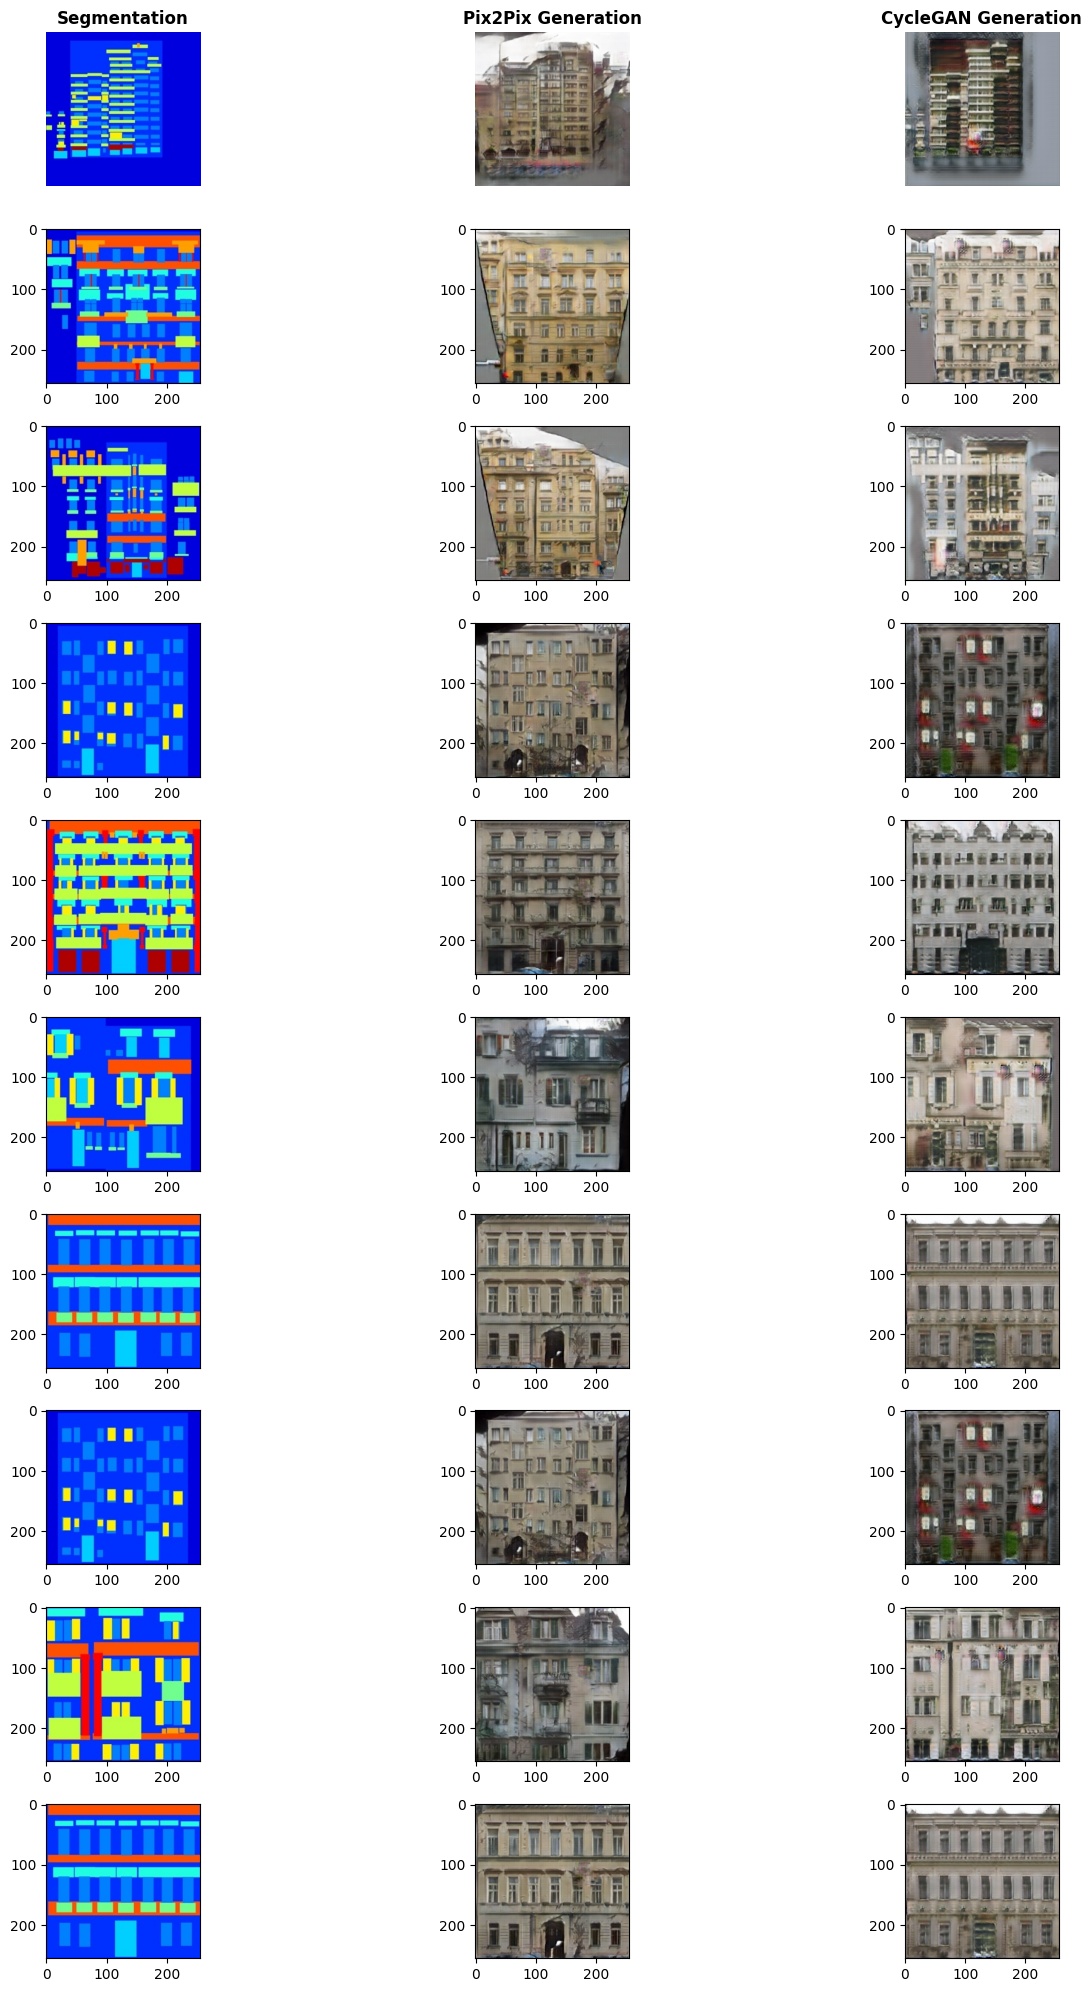

In [25]:
visualise_models_comparison(pix2pix_model, cyclegan_model, segmentation_maps, save_images=True)

## Custom images

Both networks perform average at most. Though **Pix2Pix** again looks much better than **CycleGAN**.

In [28]:
custom_examples_patches = ['examples/big_building.png', 'examples/small_house.png', 'examples/shop.png', 'examples/theatre.png']
custom_examples = [default_transforms(cv2.imread(path)) for path in custom_examples_patches]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


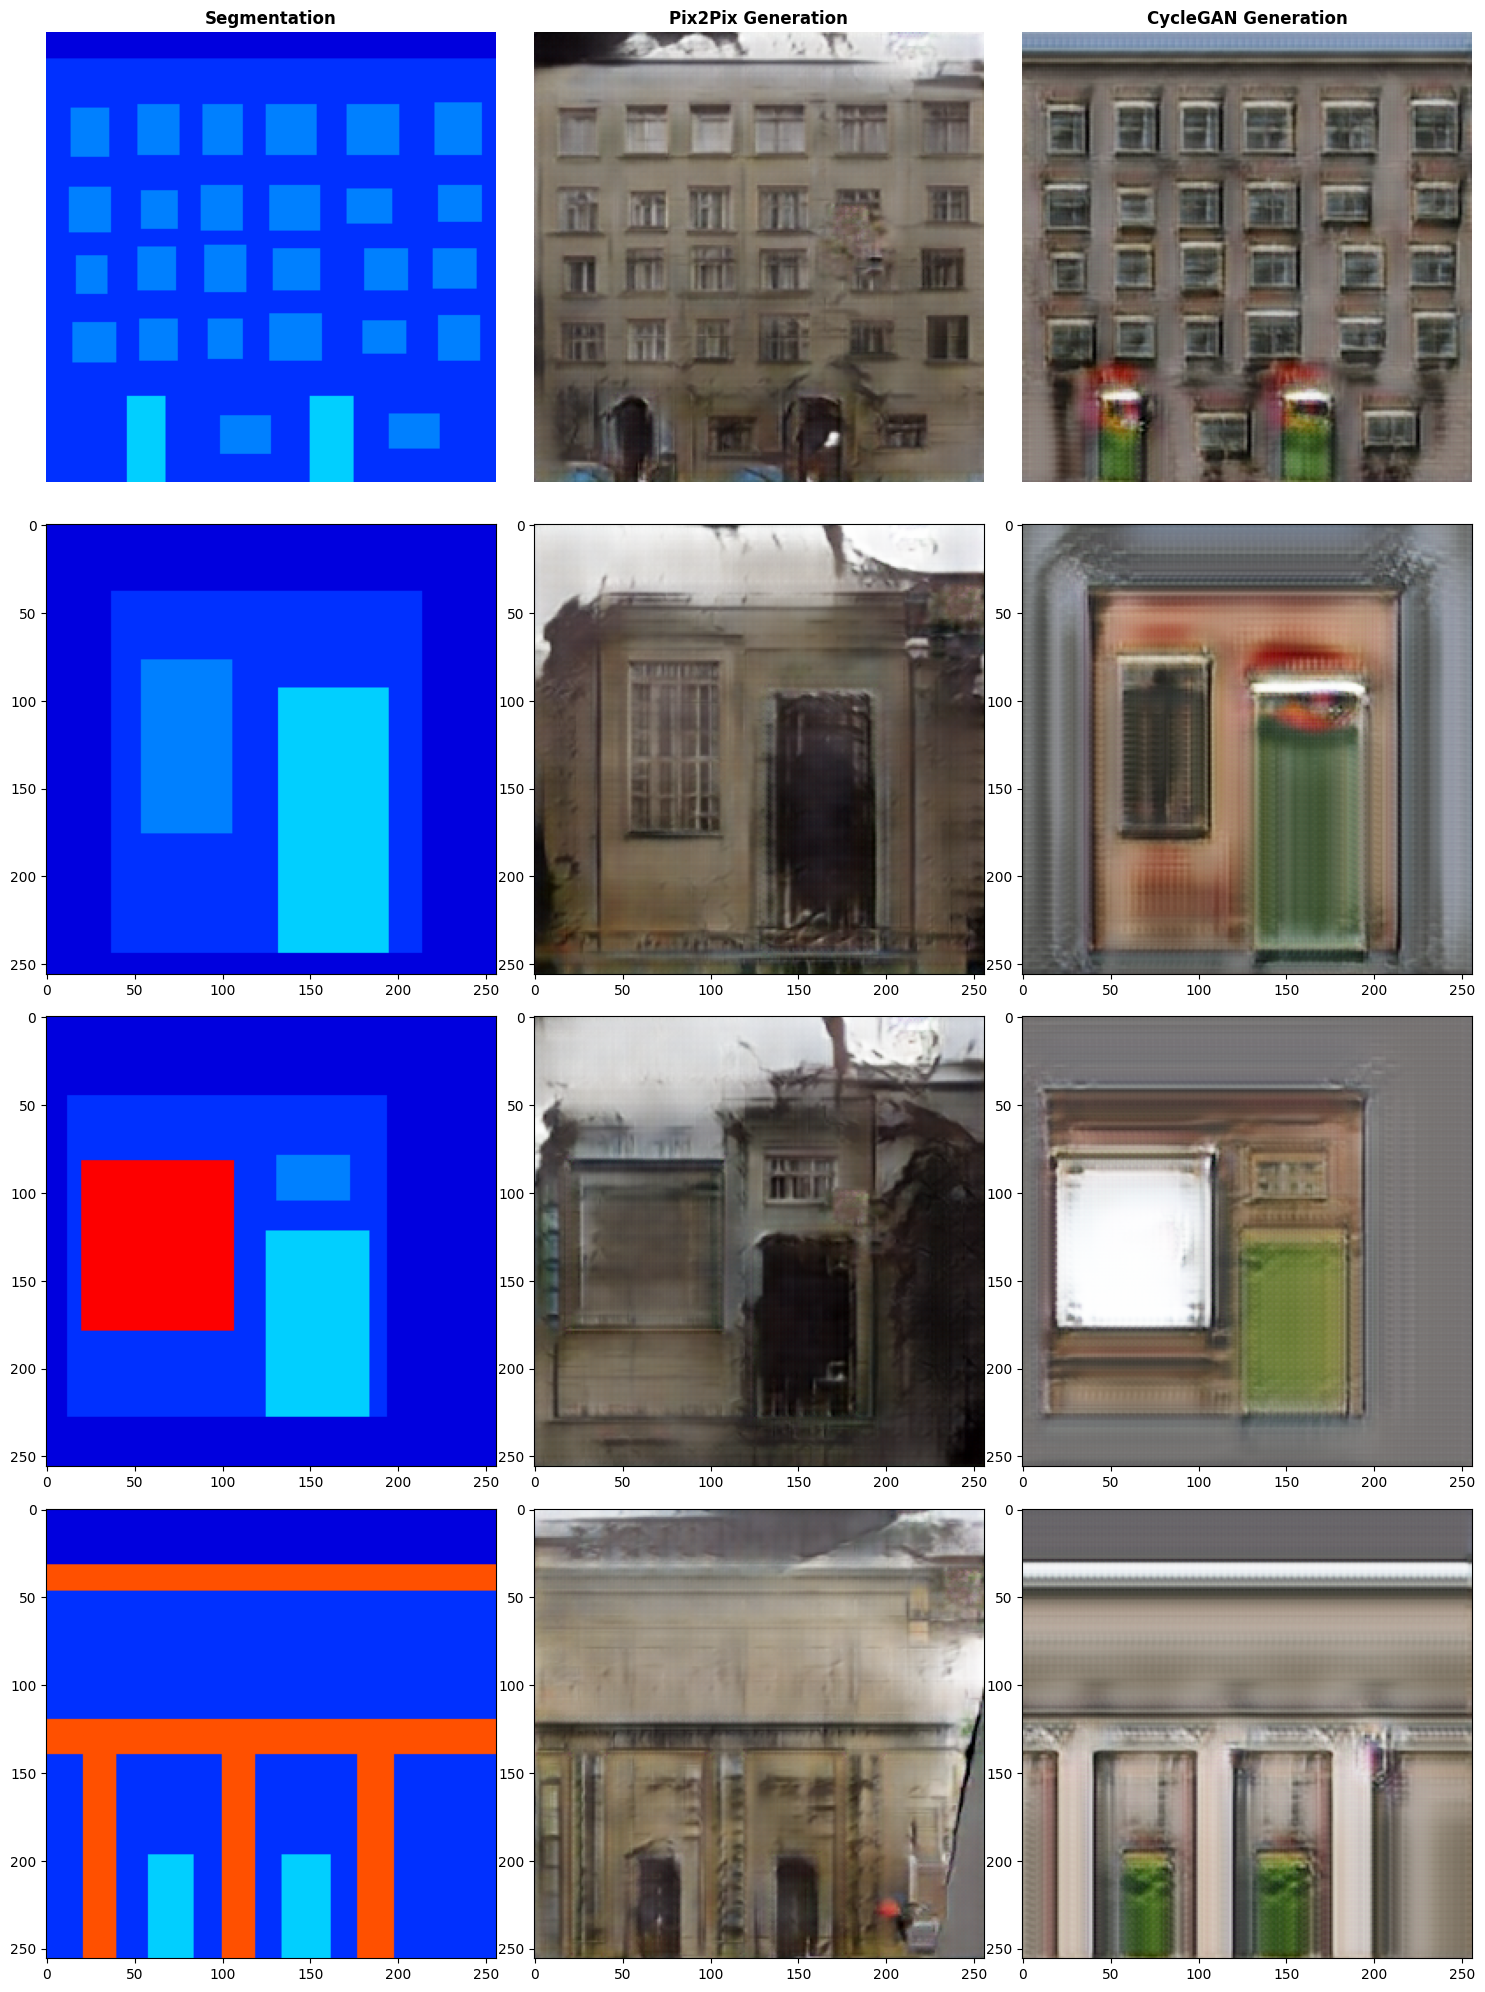

In [29]:
visualise_models_comparison(pix2pix_model, cyclegan_model, custom_examples, save_images=True)

From the results we can conclude a few things:

1. Both **Pix2Pix** and **CycleGAN** perform good and produce plausible results
2. **Pix2Pix** on average generates better images. This can be a result of:
   2.1 I trained **CycleGAN** for less epochs than **Pix2Pix**, but it seems there is some space for training left
   2.2 **CycleGAN** generates an images while **Pix2Pix** compares with a ground truth
   2.3 **CycleGAN**'s architecture seems slightly simpler than **Pix2Pix**: encoder-decoder vs. u-net like generator

I believe, it would be better to use **Pix2Pix** if your dataset has corresponding images for the generated ones.